In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [931]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [932]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [933]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [934]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [947]:
data = np.load('data/feature_extract_reshaped.npy')
data.shape

(13237, 30, 63)

In [989]:
import numpy as np

def split_data(data, test_size=0.2, val_size=0.2, random_state=None):
    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(0.8 * len(unique_epoch_ids)))
    validation_samples_nr = int(np.floor(0.2 * train_samples_nr))

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    validation_sample_ids = train_sample_ids[:validation_samples_nr]   
    train_sample_ids = [x for x in train_sample_ids if x not in validation_sample_ids]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    validation_mask = np.in1d(ids_column, validation_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    validation_sample = data[validation_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]
    X_val = validation_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]
    Y_val = validation_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)
    y_val= Y_val.max(axis=1)

    return X_train, X_test, Y_train, Y_test, X_val, Y_val, y_train, y_test, y_val


In [990]:
X_train, X_test, Y_train, Y_test, X_val, Y_val, y_train, y_test, y_val = split_data(data)
print(f'train shape', X_train.shape)
print(f'validation shape', X_val.shape)
print(f'test shape', X_test.shape)

train shape (8463, 30, 62)
validation shape (2108, 30, 62)
test shape (2666, 30, 62)


In [997]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [998]:
class_weight_dict

{0.0: 0.516266460108443, 1.0: 15.869047619047619}

In [999]:
class_weight_dict[1]

15.869047619047619

In [1010]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(72, return_sequences=False))

# Fully connected layer
model.add(Dense(72, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
#pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
#initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
#model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [886]:
y_train.shape

(2666,)

In [1011]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=100,
                    validation_data=(X_val, y_val))
                    #validation_split = 0.2)

Epoch 1/100
85/85 [==============================] - 10s 39ms/step - loss: 0.8301 - accuracy: 0.4593 - val_loss: 0.5152 - val_accuracy: 0.8800
Epoch 2/100
85/85 [==============================] - 2s 23ms/step - loss: 0.6125 - accuracy: 0.5122 - val_loss: 0.5621 - val_accuracy: 0.6731
Epoch 3/100
85/85 [==============================] - 2s 23ms/step - loss: 0.5047 - accuracy: 0.6363 - val_loss: 0.4765 - val_accuracy: 0.7116
Epoch 4/100
85/85 [==============================] - 2s 26ms/step - loss: 0.4619 - accuracy: 0.6929 - val_loss: 0.7067 - val_accuracy: 0.5636
Epoch 5/100
85/85 [==============================] - 2s 24ms/step - loss: 0.4247 - accuracy: 0.7211 - val_loss: 0.7271 - val_accuracy: 0.5759
Epoch 6/100
85/85 [==============================] - 2s 26ms/step - loss: 0.4077 - accuracy: 0.7374 - val_loss: 0.4892 - val_accuracy: 0.7177
Epoch 7/100
85/85 [==============================] - 2s 27ms/step - loss: 0.3829 - accuracy: 0.7553 - val_loss: 0.4714 - val_accuracy: 0.7514
Epoch

In [728]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

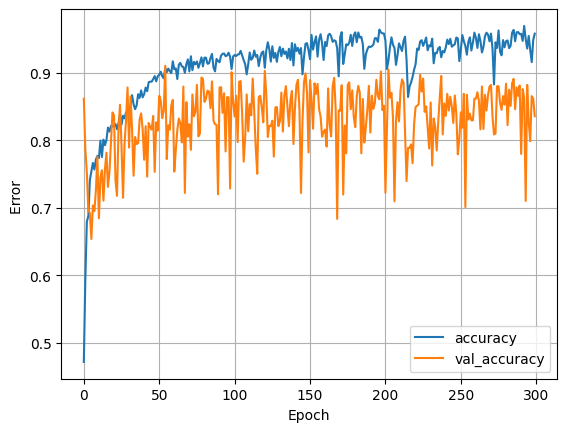

In [1002]:
plot_accuracy(history)

In [443]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

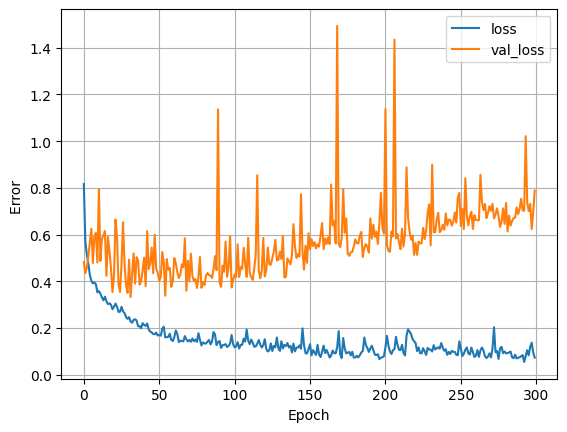

In [1003]:
plot_loss(history)

In [1004]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[0.4946192502975464, 0.8893473148345947]

In [1005]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

84/84 - 0s - loss: 0.4946 - accuracy: 0.8893 - 444ms/epoch - 5ms/step
Model accuracy: 0.8893473148345947


In [1006]:
y_pred_train = model.predict(X_train)
y_pred_train

265/265 [==============================] - 3s 7ms/step


array([[3.9230022e-06],
       [1.0766842e-09],
       [3.9028680e-11],
       ...,
       [1.1075412e-07],
       [1.1056480e-07],
       [1.2121947e-07]], dtype=float32)

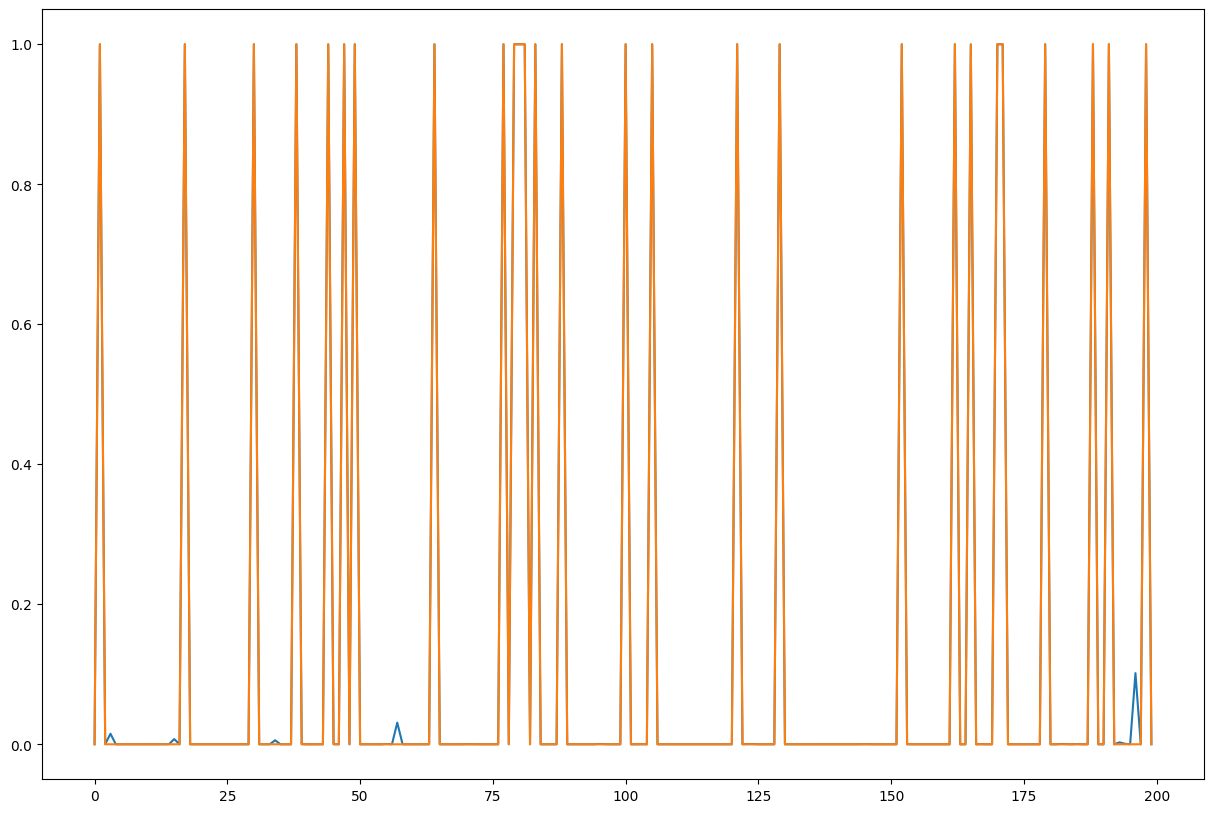

In [676]:
# plt.figure(figsize=(15,10))  # Adjust the width and height as needed
# plt.plot(y_pred_train[:200])
# plt.plot(y_train[:200])


In [1007]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

84/84 [==============================] - 1s 6ms/step


(2666, 1)

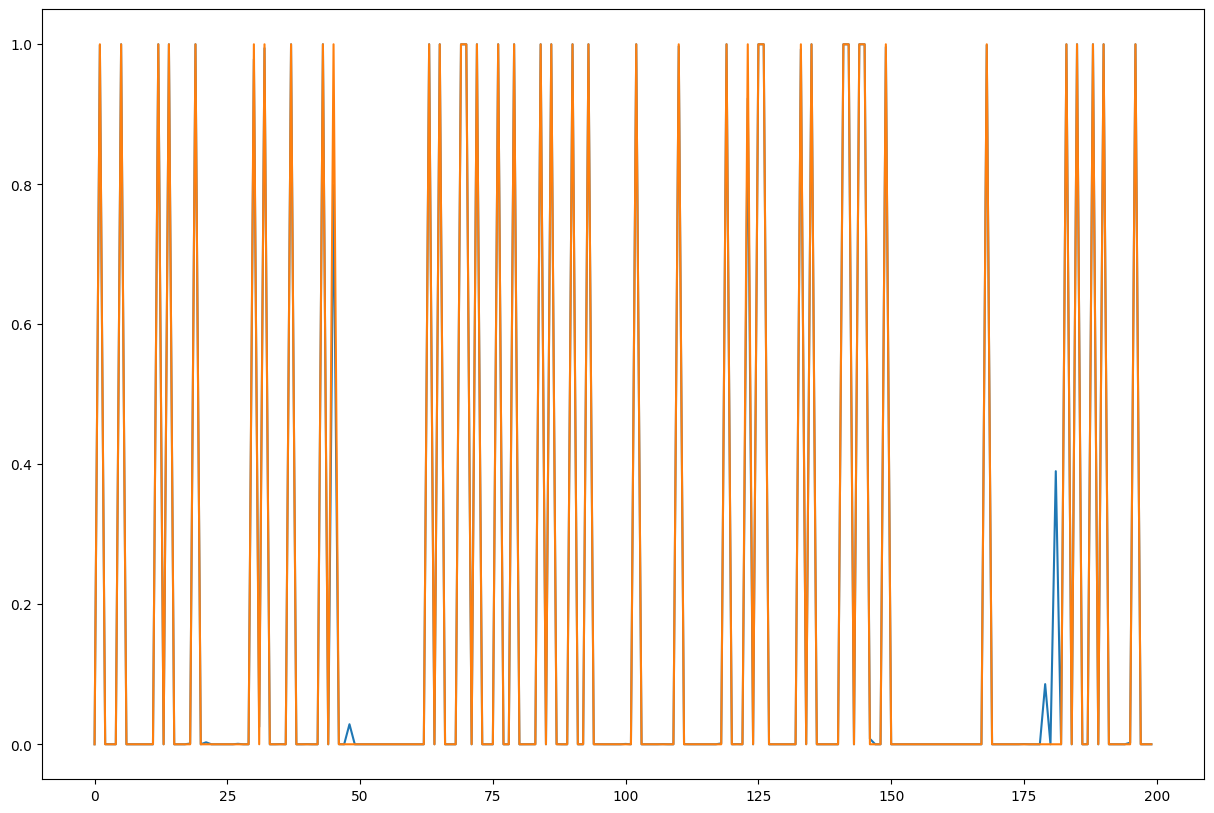

In [677]:
# plt.figure(figsize=(15,10))  
# plt.plot(y_pred[:200])
# plt.plot(y_test[:200])

In [1008]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

84/84 [==============================] - 0s 6ms/step - loss: 0.4946 - accuracy: 0.8893
Loss: 0.4946192502975464
Accuracy: 0.8893473148345947
Precision: 0.03111111111111111
Recall: 0.08333333333333333


(84.0, 225)

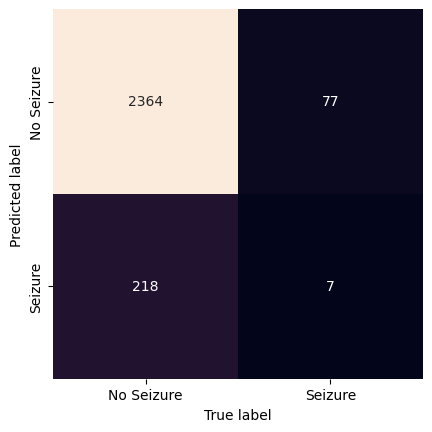

In [1009]:
from sklearn.metrics import confusion_matrix, classification_report
mat = confusion_matrix(y_test, y_pred_c)
labels = ['No Seizure', 'Seizure']
# Create the heatmap with custom labels
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [916]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82      2418
         1.0       0.18      0.60      0.28       248

    accuracy                           0.71      2666
   macro avg       0.56      0.66      0.55      2666
weighted avg       0.88      0.71      0.77      2666



Text(0, 0.5, 'Predictions')

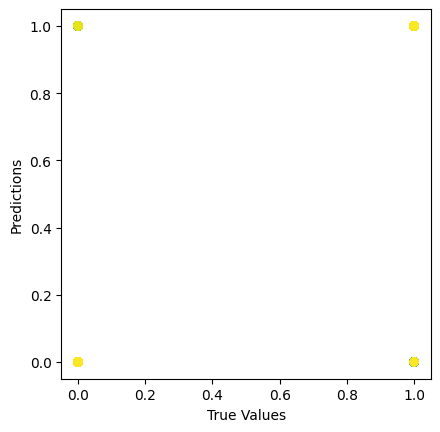

In [633]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [678]:
# error = y_pred_c - y_test
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error')
# _ = plt.ylabel('Count')

In [13]:
# def make_model(input_shape):
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [17]:
# model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [268]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     #validation_split=0.2,
#     verbose=1,


inputs: A 3D tensor with shape [batch, timesteps, feature].

In [917]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(72, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [918]:
X_train.shape

(10664, 30, 62)

In [919]:
y_train.shape

(10664,)

In [920]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_data=(X_val, y_val))

Epoch 1/300
107/107 [==============================] - 7s 28ms/step - loss: 0.8188 - accuracy: 0.2874 - val_loss: 0.4454 - val_accuracy: 0.8425
Epoch 2/300
107/107 [==============================] - 2s 16ms/step - loss: 0.7576 - accuracy: 0.2859 - val_loss: 0.5013 - val_accuracy: 0.8098
Epoch 3/300
107/107 [==============================] - 2s 16ms/step - loss: 0.7290 - accuracy: 0.3361 - val_loss: 0.5488 - val_accuracy: 0.7021
Epoch 4/300
107/107 [==============================] - 2s 16ms/step - loss: 0.7047 - accuracy: 0.4033 - val_loss: 0.5463 - val_accuracy: 0.7068
Epoch 5/300
107/107 [==============================] - 2s 15ms/step - loss: 0.6871 - accuracy: 0.4360 - val_loss: 0.5198 - val_accuracy: 0.7277
Epoch 6/300
107/107 [==============================] - 1s 13ms/step - loss: 0.6844 - accuracy: 0.4365 - val_loss: 0.8193 - val_accuracy: 0.4046
Epoch 7/300
107/107 [==============================] - 1s 13ms/step - loss: 0.6650 - accuracy: 0.4677 - val_loss: 0.5324 - val_accuracy:

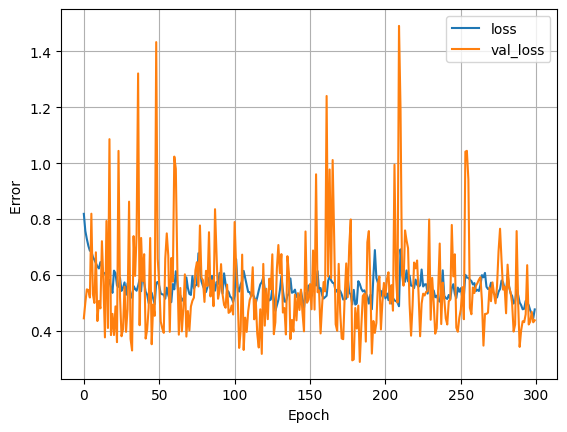

In [921]:
plot_loss(history)

In [922]:
y_pred = model.predict(X_test).flatten()
y_pred

84/84 [==============================] - 1s 3ms/step


array([2.1996491e-05, 3.9538387e-03, 4.2575654e-03, ..., 6.5730590e-01,
       6.8837935e-01, 6.5733755e-01], dtype=float32)

In [923]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

84/84 - 0s - loss: 0.9760 - accuracy: 0.5540 - 266ms/epoch - 3ms/step
Model accuracy: 0.5540134906768799


In [924]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

84/84 [==============================] - 0s 3ms/step - loss: 0.9760 - accuracy: 0.5540
Loss: 0.9759521484375
Accuracy: 0.5540134906768799
Precision: 0.12450119712689545
Recall: 0.6290322580645161


(248.0, 1253)

In [ ]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')